In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
#Set environment variables for your notebook
import os 
project_id = 'mimic-369422'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],use_local_webserver=False
)

from google.cloud import bigquery

bigquery_client = bigquery.Client()#Write Query on BQ

def run_query(query):
    return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      credentials=credentials,
      configuration={'query': {
          'useLegacySql': False
      }})

/home/jupyter-zaiman/.conda/envs/hiti/lib/python3.9/site-packages/google/auth/_default.py:79: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
crrt = run_query("""SELECT * FROM `physionet-data.mimiciv_derived.crrt`""")
icustays = run_query("""SELECT * FROM `physionet-data.mimiciv_icu.icustays`""")

In [9]:
crrt['charttime'] = pd.to_datetime(crrt['charttime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])

In [10]:
crrt_icu = crrt.merge(icustays, on='stay_id')

In [11]:
crrt_icu['time_delta'] = (crrt_icu['charttime'] - crrt_icu['intime']) / np.timedelta64(1, 'h')

In [12]:
crrt_icu = crrt_icu[crrt_icu['charttime'] > crrt_icu['intime']].reset_index(drop=True)

In [13]:
min_crrt = crrt_icu.groupby('stay_id')['charttime'].min().reset_index()

In [14]:
crrt_min = crrt_icu.merge(min_crrt)

In [15]:
crrt_min.shape

(2580, 32)

Text(0.5, 1.0, 'CRRT Incidence Distribution')

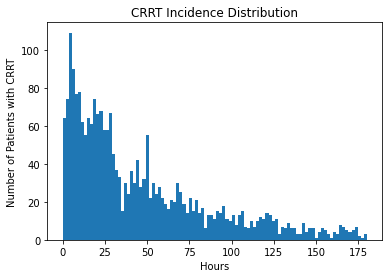

In [16]:
b= np.linspace(0, 180, 100)
plt.hist(crrt_min['time_delta'], bins=b)
plt.xlabel('Hours')
plt.ylabel('Number of Patients with CRRT')
plt.title('CRRT Incidence Distribution')

In [17]:
# Keep patients [0.5 days to 5 day window]
crrt_filt = crrt_min[(crrt_min['time_delta'] >= 12) &  (crrt_min['time_delta'] <= 120)]

In [18]:
crrt_filt.shape

(1605, 32)

In [19]:
crrt_filt.to_csv('crrt_positive_cohort.csv', index=False)